# Naive Bayes Email Spam Classifier (Manual Implementation)

This notebook implements a Naive Bayes classifier for **Email Spam** detection from scratch.
It uses the **Enron-Spam** dataset and includes rich visualizations.

In [3]:
import polars as pl
import math
import requests
import zipfile
import io
import os
from collections import defaultdict, Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## 1. Data Loading (Enron-Spam Dataset)
Downloading the Enron-Spam dataset (pre-processed CSV) from GitHub.

In [4]:
# Download dataset
url = "https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip"
csv_filename = "enron_spam_data.csv"

if not os.path.exists(csv_filename):
    print("Downloading dataset...")
    try:
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
        print("Downloaded and extracted.")
    except Exception as e:
        print(f"Failed to download/extract: {e}")

# Load data
try:
    # The CSV has columns: Message ID, Subject, Message, Spam/Ham, Date
    # We need to handle potential parsing errors
    df = pl.read_csv(csv_filename, ignore_errors=True)
    
    # Rename columns for consistency if needed, or check what they are
    print("Columns:", df.columns)
    
    # We expect 'Message' and 'Spam/Ham'
    # Let's clean up and rename
    df = df.select([
        pl.col("Subject").fill_null(""),
        pl.col("Message").fill_null(""),
        pl.col("Spam/Ham").alias("label")
    ])
    
    # Combine Subject and Message for better classification
    df = df.with_columns(
        (pl.col("Subject") + " " + pl.col("Message")).alias("text")
    )
    
    # Drop rows with missing text or label
    df = df.drop_nulls(subset=["text", "label"])
    
    print(df.head())
    print(df.group_by("label").len())
    
except Exception as e:
    print(f"Error loading data: {e}")

Columns: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']
shape: (5, 4)
┌──────────────────────────────┬─────────────────────────────┬───────┬─────────────────────────────┐
│ Subject                      ┆ Message                     ┆ label ┆ text                        │
│ ---                          ┆ ---                         ┆ ---   ┆ ---                         │
│ str                          ┆ str                         ┆ str   ┆ str                         │
╞══════════════════════════════╪═════════════════════════════╪═══════╪═════════════════════════════╡
│ christmas tree farm pictures ┆                             ┆ ham   ┆ christmas tree farm         │
│                              ┆                             ┆       ┆ pictures                    │
│ vastar resources , inc .     ┆ gary , production from the  ┆ ham   ┆ vastar resources , inc .    │
│                              ┆ hig…                        ┆       ┆ gary …                      │
│ calpine d

## 2. Exploratory Data Analysis (EDA)
Visualizing the dataset characteristics.

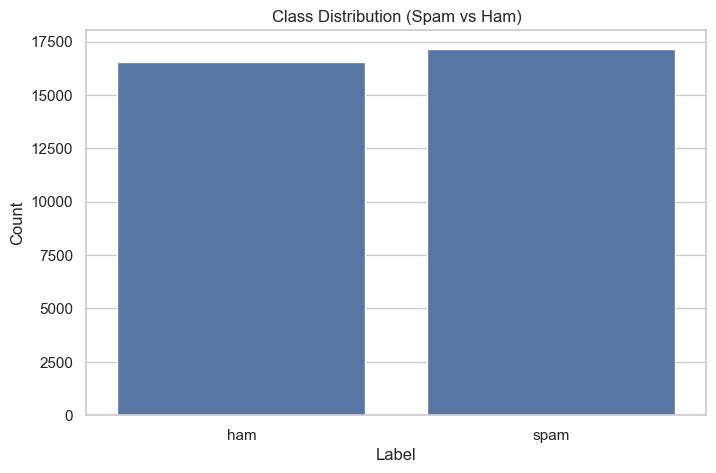

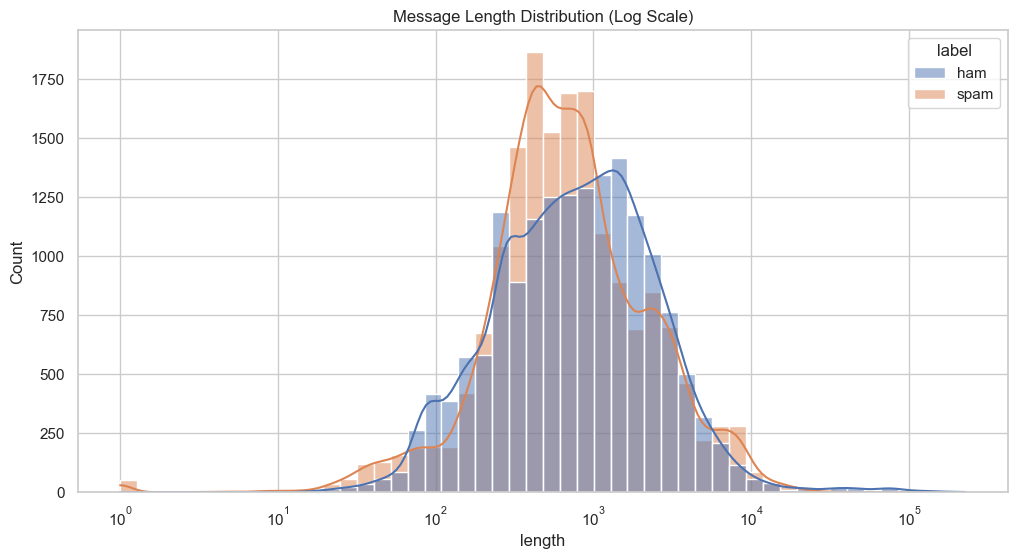

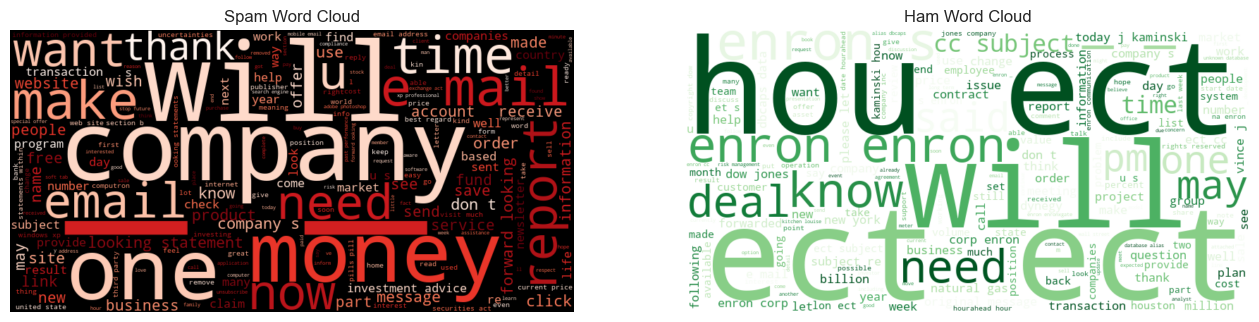

In [5]:
# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["label"].to_list())
plt.title("Class Distribution (Spam vs Ham)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Message Length Distribution
df = df.with_columns(
    pl.col("text").str.len_chars().alias("length")
)

# Use dictionary for plotting to avoid pyarrow dependency (needed for to_pandas)
plot_data = {
    "length": df["length"].to_list(),
    "label": df["label"].to_list()
}

plt.figure(figsize=(12, 6))
sns.histplot(data=plot_data, x="length", hue="label", bins=50, log_scale=True, kde=True)
plt.title("Message Length Distribution (Log Scale)")
plt.show()

# Word Clouds
spam_text = " ".join(df.filter(pl.col("label") == "spam")["text"].to_list())
ham_text = " ".join(df.filter(pl.col("label") == "ham")["text"].to_list())

wordcloud_spam = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_text)
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_text)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Spam Word Cloud")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("Ham Word Cloud")
plt.axis('off')
plt.show()

## 3. Preprocessing 
Tokenization and Vocabulary Building.

In [6]:
def tokenize(text):
    if text is None:
        return []
    text = text.lower()
    # Keep only alpha characters for cleaner tokens in emails
    cleaned_text = "".join(c if c.isalpha() or c.isspace() else " " for c in text)
    return [w for w in cleaned_text.split() if len(w) > 1] # Remove single chars

df = df.with_columns(
    pl.col("text").map_elements(tokenize, return_dtype=pl.List(pl.String)).alias("tokens")
)

# Train/Test Split
random.seed(42)
rows = df.to_dicts()
random.shuffle(rows)

split_idx = int(len(rows) * 0.8)
train_data = rows[:split_idx]
test_data = rows[split_idx:]

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 26972
Test size: 6744


## 4. Model Training (Manual Naive Bayes)
Calculating Priors and Likelihoods.

In [7]:
# Vocabulary (Top N words to avoid huge dimensionality if needed, but we'll try full vocab first)
vocab_counts = Counter()
for row in train_data:
    vocab_counts.update(row["tokens"])

vocab = [w for w, c in vocab_counts.most_common(10000)]
vocab_set = set(vocab)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

spam_messages = [row for row in train_data if row["label"] == "spam"]
ham_messages = [row for row in train_data if row["label"] == "ham"]

p_spam = len(spam_messages) / len(train_data)
p_ham = len(ham_messages) / len(train_data)
print(f"P(Spam): {p_spam:.4f}")
print(f"P(Ham): {p_ham:.4f}")


#Use the words as the keys and the counts as the frequency values 
# in the spam and ham messages
spam_word_counts = defaultdict(int)
for row in spam_messages:
    for word in row["tokens"]:
        if word in vocab_set:
            spam_word_counts[word] += 1

ham_word_counts = defaultdict(int)
for row in ham_messages:
    for word in row["tokens"]:
        if word in vocab_set:
            ham_word_counts[word] += 1

total_spam_words = sum(spam_word_counts.values())
total_ham_words = sum(ham_word_counts.values())

spam_log_likelihoods = {}
ham_log_likelihoods = {}

denom_spam = total_spam_words + vocab_size
denom_ham = total_ham_words + vocab_size

for word in vocab:
    spam_log_likelihoods[word] = math.log((spam_word_counts[word] + 1) / denom_spam)
    ham_log_likelihoods[word] = math.log((ham_word_counts[word] + 1) / denom_ham)

default_spam_log_likelihood = math.log(1 / denom_spam)
default_ham_log_likelihood = math.log(1 / denom_ham)

Vocabulary size: 10000
P(Spam): 0.5067
P(Ham): 0.4933


## 5. Prediction and Evaluation
Predicting and visualizing results.

Accuracy: 0.9795


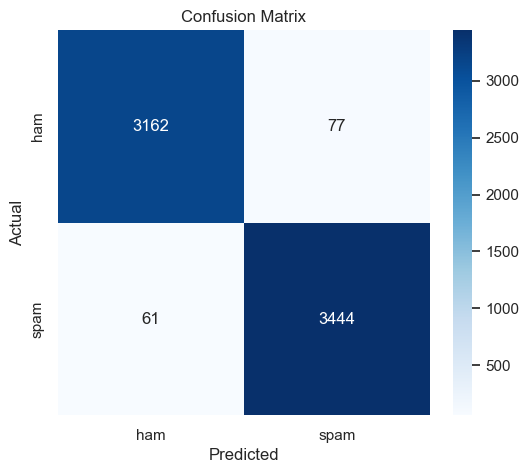

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      3239
        spam       0.98      0.98      0.98      3505

    accuracy                           0.98      6744
   macro avg       0.98      0.98      0.98      6744
weighted avg       0.98      0.98      0.98      6744



In [8]:
def predict(tokens):
    log_prob_spam = math.log(p_spam)
    log_prob_ham = math.log(p_ham)
    
    for word in tokens:
        if word in spam_log_likelihoods:
            log_prob_spam += spam_log_likelihoods[word]
            log_prob_ham += ham_log_likelihoods[word]
        else:
            # Word not in vocab (unseen)
            pass
            
    return "spam" if log_prob_spam > log_prob_ham else "ham"

y_true = []
y_pred = []

for row in test_data:
    prediction = predict(row["tokens"])
    y_true.append(row["label"])
    y_pred.append(prediction)

# Metrics
correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
accuracy = correct / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

# Debugging if accuracy is low
if accuracy < 0.6:
    print("WARNING: Low accuracy detected. Debugging...")
    print("Sample predictions:")
    for i in range(10):
        print(f"Actual: {y_true[i]}, Predicted: {y_pred[i]}")
    
    print(f"P(Spam): {p_spam}, P(Ham): {p_ham}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred, labels=["ham", "spam"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred))

## 6. Word Clouds from Predictions
Visualize the vocabulary the model *learned* by creating word clouds from predicted labels.

In [ ]:
# Separate test data by PREDICTED labels
predicted_spam_emails = []
predicted_ham_emails = []

for row, prediction in zip(test_data, y_pred):
    if prediction == "spam":
        predicted_spam_emails.append(row["text"])
    else:
        predicted_ham_emails.append(row["text"])

# Create text from predicted labels
predicted_spam_text = " ".join(predicted_spam_emails)
predicted_ham_text = " ".join(predicted_ham_emails)

# Filter out specific words manually
words_to_remove = ['will', 'enron', 'ect', 'hou', 'said', 'one', 'time', 'may', 'can']
for word in words_to_remove:
    predicted_spam_text = predicted_spam_text.replace(f' {word} ', ' ')
    predicted_spam_text = predicted_spam_text.replace(f' {word.capitalize()} ', ' ')
    predicted_ham_text = predicted_ham_text.replace(f' {word} ', ' ')
    predicted_ham_text = predicted_ham_text.replace(f' {word.capitalize()} ', ' ')

# Add custom stopwords to WordCloud's default set
from wordcloud import STOPWORDS
custom_stopwords = STOPWORDS.copy()
custom_stopwords.update(words_to_remove)

# Generate Word Clouds from PREDICTIONS
wordcloud_pred_spam = WordCloud(width=800, height=400, background_color='black', colormap='Reds', stopwords=custom_stopwords).generate(predicted_spam_text)
wordcloud_pred_ham = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=custom_stopwords).generate(predicted_ham_text)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pred_spam, interpolation='bilinear')
plt.title('Predicted SPAM Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pred_ham, interpolation='bilinear')
plt.title('Predicted HAM Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Predicted Spam Emails: {len(predicted_spam_emails)}")
print(f"Predicted Ham Emails: {len(predicted_ham_emails)}")